In [1]:
#cfbd==4.5.2

In [2]:
import time
start_time = time.time()

In [3]:
#parameters
current_year = None
current_week = None
client_name = None

In [4]:
if not (current_year or current_week or client_name):
    current_year = 2024
    current_week = 9
    client_name = "notebook"

In [5]:
start_year = 2022

current_year_week = f"{current_year}_{current_week}"

In [6]:
#distance travveled latitude and longitude
# https://collegefootballdata.com/glossary

# Imports

In [7]:
from __future__ import print_function
import os
import numpy as np
import cfbd
from pprint import pprint
import pandas as pd
import datetime

import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = [20,10]

In [ ]:
from pathlib import Path

DATA_DIR = "./starter_pack_data"

import numpy as np

def safe_bool(val):
    if pd.isna(val):
        return np.nan
    val_str = str(val).strip().lower()
    return val_str in ['true', '1', 'yes']

games_csv = pd.read_csv(
    f"{DATA_DIR}/games.csv", 
    converters={
        'start_time_tbd': safe_bool,
        'conference_game': safe_bool,
        'notes': str
    })
games_csv = games_csv[games_csv['season'] >= start_year].copy()
games_csv = games_csv[games_csv['season'] < 2024].copy()


advanced_game_stats_csv = pd.DataFrame()
for year in range(start_year-1, 2024): #up to 2024

    for file in Path(f"{DATA_DIR}/advanced_game_stats").glob(f"{year}*.csv"):
        temp_df = pd.read_csv(file)
        advanced_game_stats_csv = pd.concat([advanced_game_stats_csv, temp_df], ignore_index=True)


In [ ]:
import re

configuration = cfbd.Configuration(
    access_token = os.environ["CFBD_API_KEY"]
)

games_api_df = pd.DataFrame()
advanced_game_stats_api_df = pd.DataFrame()

lines_api_df = pd.DataFrame()
epa_by_game_api_df = pd.DataFrame()

def camel_to_snake(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    s2 = re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1)
    return s2.lower()



with cfbd.ApiClient(configuration) as api_client:
    betting_api = cfbd.BettingApi(api_client)
    game_api = cfbd.GamesApi(api_client)
    metrics_api = cfbd.MetricsApi(api_client)
    adjusted_metrics_api = cfbd.AdjustedMetricsApi(api_client)
    stats_api = cfbd.StatsApi(api_client)

    # year = 2024 # int | Optional year filter (optional)
    # team = 'Texas' # str | Optional team filter (optional)
    # conference = 'SEC' # str | Optional conference abbreviation filter (optional)
    # position = 'QB' # str | Optional position abbreviation filter (optional)
    season_type = 'regular'

    for year in range(start_year-1 , current_year+1):
        temp_lines = pd.DataFrame([element.to_dict() for element in betting_api.get_lines(year=year, season_type = season_type)])
        temp_lines.columns = [camel_to_snake(col) for col in temp_lines.columns]
        lines_api_df = pd.concat([lines_api_df, temp_lines])

        if year > games['season'].max():
            temp_games = pd.DataFrame([element.to_dict() for element in game_api.get_games(year=year, season_type = season_type)])
            temp_games.columns = [camel_to_snake(col) for col in temp_games.columns]
            games_api_df = pd.concat([games_api_df, temp_games])

        epa_by_game_temp = pd.DataFrame([element.to_dict() for element in metrics_api.get_predicted_points_added_by_game(year=year, season_type = season_type)])
        epa_by_game_temp.columns = [camel_to_snake(col) for col in epa_by_game_temp.columns]
        epa_by_game_api_df = pd.concat([epa_by_game_api_df, epa_by_game_temp])

        if year > advanced_game_stats['season'].max():
            advanced_game_stats_temp = pd.DataFrame([element.to_dict() for element in stats_api.get_advanced_game_stats(year=year, season_type = season_type)])
            advanced_game_stats_temp.columns = [camel_to_snake(col) for col in advanced_game_stats_temp.columns]
            advanced_game_stats_api_df = pd.concat([advanced_game_stats_api_df, advanced_game_stats_temp])

        print(f"{year} done.")

2021 done.
2022 done.
2023 done.
2024 done.


#### Games cleanup

In [ ]:
games_clean = games_api_df.reset_index(drop=True).copy()
games_clean["season_type"] = games_clean["season_type"].apply(lambda x: x.value if hasattr(x, "value") else x)
games_clean["home_classification"] = games_clean["home_classification"].apply(lambda x: x.value if hasattr(x, "value") else x)
games_clean["away_classification"] = games_clean["away_classification"].apply(lambda x: x.value if hasattr(x, "value") else x)
games_clean = games_clean.drop(['highlights', 'venue'], axis=1)

In [ ]:
game_rename_map = {
    "status": "completed",
    "excitement": "excitement_index",
    "home_team_id": "home_id",
    "away_team_id": "away_id",
    "home_postgame_win_prob": "home_postgame_win_probability",
    "away_postgame_win_prob": "away_postgame_win_probability",
    "home_start_elo": "home_pregame_elo",
    "home_end_elo":   "home_postgame_elo",
    "away_start_elo": "away_pregame_elo",
    "away_end_elo":   "away_postgame_elo",
}

games_csv_clean = games_csv.reset_index(drop=True).copy()
games_csv_clean = games_csv.rename(columns=game_rename_map, errors="ignore")
games_csv_clean["completed"] = games_csv_clean["completed"].eq("completed")
games_csv_clean["start_date"] = (pd.to_datetime(games_csv_clean["start_date"], utc=True, errors="coerce"))
games_csv_clean = games_csv_clean.drop(['away_conference_id', 'home_conference_id'], axis=1)

games_csv_clean = games_csv_clean[list(games_clean.columns)]

In [55]:
games = pd.concat(
    [games_csv_clean, games_clean],      
    ignore_index=True,  
    sort=False          
)

#### Lines cleanup

In [ ]:
lines_clean = lines_api_df.reset_index(drop=True).copy()
lines_clean["season_type"] = lines_clean["season_type"].apply(lambda x: x.value if hasattr(x, "value") else x)
lines_clean["home_classification"] = lines_clean["home_classification"].apply(lambda x: x.value if hasattr(x, "value") else x)
lines_clean["away_classification"] = lines_clean["away_classification"].apply(lambda x: x.value if hasattr(x, "value") else x)

lines=lines_clean.copy()

#### EPA cleanup

In [ ]:
epa_clean = epa_by_game_api_df.reset_index(drop=True).copy()

epa_clean["season_type"] = epa_clean["season_type"].apply(lambda x: x.value if hasattr(x, "value") else x)

offense_df = epa_clean['offense'].apply(pd.Series)
offense_df.columns = [camel_to_snake(col) for col in offense_df.columns]
offense_df = offense_df.add_prefix('offense_')

defence_df = epa_clean['defense'].apply(pd.Series)
defence_df.columns = [camel_to_snake(col) for col in defence_df.columns]
defence_df = defence_df.add_prefix('defense_')

epa_clean = epa_clean.drop(columns=['offense']).join(offense_df)
epa_clean = epa_clean.drop(columns=['defense']).join(defence_df)

epa = epa_clean.copy()

#### Advanced stats cleanup

In [202]:
advanced_game_stats_clean = advanced_game_stats_api_df.reset_index(drop=True).copy()

offense_df = advanced_game_stats_clean['offense'].apply(pd.Series)
o_passing_plays = offense_df['passingPlays'].apply(pd.Series).add_prefix('passing_plays_')
o_rushing_plays = offense_df['rushingPlays'].apply(pd.Series).add_prefix('rushing_plays_')
o_passing_downs = offense_df['passingDowns'].apply(pd.Series).add_prefix('passing_downs_')
o_standard_downs = offense_df['standardDowns'].apply(pd.Series).add_prefix('standard_downs_')
offense_df = pd.concat(
    [offense_df.drop(columns=['passingPlays', 'rushingPlays', 'passingDowns', 'standardDowns']),
     o_passing_plays, o_rushing_plays, o_passing_downs, o_standard_downs],
    axis=1
)
offense_df.columns = [camel_to_snake(col) for col in offense_df.columns]
offense_df = offense_df.add_prefix('offense_')

defence_df = advanced_game_stats_clean['defense'].apply(pd.Series)
d_passing_plays = defence_df['passingPlays'].apply(pd.Series).add_prefix('passing_plays_')
d_rushing_plays = defence_df['rushingPlays'].apply(pd.Series).add_prefix('rushing_plays_')
d_passing_downs = defence_df['passingDowns'].apply(pd.Series).add_prefix('passing_downs_')
d_standard_downs = defence_df['standardDowns'].apply(pd.Series).add_prefix('standard_downs_')
defence_df = pd.concat(
    [defence_df.drop(columns=['passingPlays', 'rushingPlays', 'passingDowns', 'standardDowns']),
     d_passing_plays, d_rushing_plays, d_passing_downs, d_standard_downs],
    axis=1
)
defence_df.columns = [camel_to_snake(col) for col in defence_df.columns]
defence_df = defence_df.add_prefix('defense_')


advanced_game_stats_clean = advanced_game_stats_clean.drop(columns=['offense']).join(offense_df)
advanced_game_stats_clean = advanced_game_stats_clean.drop(columns=['defense']).join(defence_df)


In [ ]:
advanced_game_stats_csv_clean  = advanced_game_stats_csv.reset_index(drop=True).copy()
advanced_game_stats_csv_clean.columns = [camel_to_snake(col) for col in advanced_game_stats_csv_clean.columns]

advanced_game_stats_csv_clean = advanced_game_stats_csv_clean[list(advanced_game_stats_clean.columns)]

In [204]:
advanced_game_stats = pd.concat(
    [advanced_game_stats_csv_clean, advanced_game_stats_clean],      
    ignore_index=True,  
    sort=False          
)

# Games

In [205]:
schedule_cols = ['id', 'season', 'week', 'home_team', 'away_team', 'neutral_site', 'conference_game', 'venue_id', 'start_date', 'home_conference', 'away_conference', 'home_points', 'away_points', 'home_classification', 'away_classification']
schedule = games.copy()[schedule_cols]

schedule['game_id'] = schedule['id']
schedule['timestamp'] = pd.to_datetime(schedule['start_date'])
schedule['weekday'] = schedule['timestamp'].dt.day_name()
schedule['date'] = schedule['timestamp'].dt.date
schedule = schedule.sort_values(by='timestamp') #needed for correct elo calculations

## ELO ratings

In [206]:
def get_elo_win_pct(rating, opp_rating):
    exp = (opp_rating - rating) / 400 #increasing divisor will widen rarting scale
    return 1 / (1 + 10**exp)

def get_new_elos(home_rating, away_rating, margin):
    k = 25 # largest amount elo can change from a single game, higher is more volitile

    home_score = 0.5 # score of 0.5 for a tie
    if margin > 0:
        home_score = 1 # score of 1 for a win
    elif margin < 0:
        home_score = 0 # score of 0 for a loss

    
    expected_home_score = get_elo_win_pct(home_rating, away_rating)
    new_home_score = home_rating + k * (home_score - expected_home_score) 

    away_score = 1 - home_score
    expected_away_score = get_elo_win_pct(away_rating, home_rating)
    new_away_score = away_rating + k * (away_score - expected_away_score)

    return (round(new_home_score), round(new_away_score))

In [207]:
teams = dict()
pregame_home_elos = []
pregame_away_elos = []
postgame_home_elos = []
postgame_away_elos = []

for _, game in schedule.iterrows():
    
    if game['home_team'] in teams:
        home_elo = teams[game['home_team']]
    elif game['home_classification'] == 'fbs':
        home_elo = 1500
    else:
        home_elo = 1200

    if game['away_team'] in teams:
        away_elo = teams[game['away_team']]
    elif game['away_classification'] == 'fbs':
        away_elo = 1500
    else:
        away_elo = 1200

    margin = game['home_points'] - game['away_points']
    new_elos = get_new_elos(home_elo, away_elo, margin)

    pregame_home_elos.append(home_elo)
    pregame_away_elos.append(away_elo)

    postgame_home_elos.append(new_elos[0])
    postgame_away_elos.append(new_elos[1])

    teams[game['home_team']] = new_elos[0]
    teams[game['away_team']] = new_elos[1]

schedule['home_pregame_elo'] = pregame_home_elos
schedule['away_pregame_elo'] = pregame_away_elos
schedule['home_postgame_elo'] = postgame_home_elos
schedule['away_postgame_elo'] = postgame_away_elos

# Betting

In [208]:
import random

def get_preferred_provider_dict(dict_list):
    preferred_providers = ['DraftKings', 'ESPN Bet', 'Bovada', 'consensus']
    for provider in preferred_providers:
        for d in dict_list:
            if d.get('provider') == provider:
                return d

    return random.choice(dict_list) if dict_list else {}

def get_implied_totals(row):
    home_points = (row['over_under'] / 2) + (row['spread'] / 2)
    away_points = (row['over_under'] / 2) - (row['spread'] / 2)
    return pd.Series([home_points, away_points])

provider_series = lines['lines'].apply(get_preferred_provider_dict)
provider_df = pd.DataFrame(provider_series.tolist())
exploded_lines = lines.join(provider_df).reset_index(drop = True)
exploded_lines.columns = [camel_to_snake(col) for col in exploded_lines.columns]
exploded_lines = exploded_lines[['id', 'lines', 'provider', 'spread', 'spread_open', 'over_under', 'over_under_open', 'home_moneyline', 'away_moneyline']]
exploded_lines[['implied_points_home', 'implied_points_away']] = exploded_lines.apply(get_implied_totals, axis=1)

# EPA

In [99]:
def dynamic_window_ewma(x, col_shifted):
    """
    Calculate rolling exponentially weighted average with a dynamic window size for a given column.
    """
    values = np.zeros(len(x))
    for i, (_, row) in enumerate(x.iterrows()):
        epa_col = x[col_shifted][:i+1]
        if row['week'] > 10:
            span = row['week']
        else:
            span = 10
        values[i] = epa_col.ewm(min_periods=1, span=span).mean().iloc[-1]
    return pd.Series(values, index=x.index)


def get_averaged_game_stats(df, columns):

    for col in columns:
        col_shifted = f'{col}_shifted'
        col_ewma = f'{col}_ewma'
        col_ewma_dynamic_window = f'{col}_ewma_dynamic_window'

        # Shift the column data
        df[col_shifted] = df.groupby('team')[col].shift()

        # Calculate the EWMA with a fixed span of 10
        df[col_ewma] = df.groupby('team')[col_shifted].transform(lambda x: x.ewm(min_periods=1, span=10).mean())

        # Calculate the EWMA with a dynamic window
        df[col_ewma_dynamic_window] = df.groupby('team').apply(
            lambda x: dynamic_window_ewma(x, col_shifted)
        ).reset_index(level=0, drop=True)

        return df

columns = ['offense_overall', 'offense_passing', 'offense_rushing',
           'offense_first_down', 'offense_second_down', 'offense_third_down',
           'defense_overall', 'defense_passing', 'defense_rushing',
           'defense_first_down', 'defense_second_down', 'defense_third_down']

epa = get_averaged_game_stats(epa, columns)
    
epa.head()

,index,game_id,season,week,season_type,team,conference,opponent,offense_third_down,offense_second_down,...,offense_overall,defense_third_down,defense_second_down,defense_first_down,defense_rushing,defense_passing,defense_overall,offense_overall_shifted,offense_overall_ewma,offense_overall_ewma_dynamic_window
0,0,401310861,2021,1,SeasonType.REGULAR,Air Force,Mountain West,Lafayette,0.76,0.16,...,0.37,1.01,-0.08,-0.03,0.18,0.35,0.24,NaN,NaN,NaN
1,1,401281944,2021,1,SeasonType.REGULAR,Akron,Mid-American,Auburn,0.26,0.22,...,0.19,0.91,0.70,0.80,0.81,0.74,0.78,NaN,NaN,NaN
2,2,401281942,2021,1,SeasonType.REGULAR,Alabama,SEC,Miami,1.11,-0.03,...,0.34,0.53,-0.25,-0.07,-0.12,0.10,0.01,NaN,NaN,NaN
3,3,401300993,2021,1,SeasonType.REGULAR,App State,Sun Belt,East Carolina,0.19,-0.02,...,0.35,0.25,-0.26,0.32,0.18,0.20,0.20,NaN,NaN,NaN
4,4,401309841,2021,1,SeasonType.REGULAR,Arizona,Pac-12,BYU,-0.03,-0.03,...,0.11,0.88,0.16,-0.03,0.09,0.48,0.25,NaN,NaN,NaN


# Avanced Game Stats

In [163]:
columns = ['offense_explosiveness', 'defense_explosiveness']

game_stats = get_averaged_game_stats(advanced_game_stats, columns)
game_stats.head()

,game_id,season,week,team,opponent,offense_passing_plays_explosiveness,offense_passing_plays_success_rate,offense_passing_plays_total_ppa,offense_passing_plays_ppa,offense_rushing_plays_explosiveness,...,defense_power_success,defense_explosiveness,defense_success_rate,defense_total_ppa,defense_ppa,defense_drives,defense_plays,offense_explosiveness_shifted,offense_explosiveness_ewma,offense_explosiveness_ewma_dynamic_window
0,401281942,2021,1,Alabama,Miami,1.771177,0.525000,25.441672,0.636042,0.846216,...,0.750000,1.044124,0.365079,0.353891,0.005617,13,63,NaN,NaN,NaN
1,401281942,2021,1,Miami,Alabama,1.433289,0.333333,3.557432,0.098818,0.619581,...,0.400000,1.357379,0.500000,26.187401,0.344571,12,76,NaN,NaN,NaN
2,401281943,2021,1,Arkansas,Rice,1.130748,0.318182,0.585939,0.026634,1.038049,...,0.666667,1.097663,0.306667,-6.850570,-0.091341,15,75,NaN,NaN,NaN
3,401281943,2021,1,Rice,Arkansas,1.602289,0.400000,10.064247,0.287550,0.312689,...,0.500000,1.058981,0.476923,15.569727,0.239534,15,65,NaN,NaN,NaN
4,401281944,2021,1,Akron,Auburn,1.496938,0.375000,13.038492,0.325962,1.264422,...,1.000000,1.247167,0.709677,48.427795,0.781093,11,62,NaN,NaN,NaN


# Form df

In [167]:
df = schedule.merge(epa.rename(columns={'team': 'home_team'}), on=['home_team', 'game_id', 'season', 'week'], how='left')\
.merge(epa.rename(columns={'team': 'away_team'}), on=['away_team', 'game_id', 'season', 'week'], how='left', suffixes=('_home', '_away'))

df = df.merge(game_stats.rename(columns={'team': 'home_team'}), on=['home_team', 'game_id', 'week'], how='left')\
.merge(game_stats.rename(columns={'team': 'away_team'}), on=['away_team', 'game_id', 'week'], how='left', suffixes=('_home', '_away'))

df = df.merge(exploded_lines, on=['id'], how='left')

/var/folders/y6/0gg0l5_927jfzt4rnq96nwtr0000gp/T/ipykernel_76397/3793080087.py:5: FutureWarning: Passing 'suffixes' which cause duplicate columns {'opponent_home'} in the result is deprecated and will raise a MergeError in a future version.
  .merge(game_stats.rename(columns={'team': 'away_team'}), on=['away_team', 'game_id', 'week'], how='left', suffixes=('_home', '_away'))


In [216]:
df = df.dropna(subset=['home_team', 'provider', 'home_moneyline'])

In [ ]:
import matplotlib.pyplot as plt

# This is the styling I use. Check out other themes here: https://matplotlib.org/3.2.1/gallery/style_sheets/style_sheets_reference.html
plt.style.use('fivethirtyeight')

# Graph sizing
plt.rcParams["figure.figsize"] = [20,10]

In [160]:
melted_schedule_teams = pd.melt(games, id_vars=['season', 'week'], value_vars=['home_team', 'away_team'], value_name='team').drop('variable', axis=1).reset_index(drop=True)[['season', 'week', 'team']]
pbp['rz'] = np.where(pbp['yards_to_goal'] >= 20, 1, 0)
pbp['epa'] = pbp['ppa']

In [148]:

df = games[game_cols].merge(exploded_lines, on='id', how='left')
df

,id,season,week,home_team,away_team,weekday,neutral_site,conference_game,venue_id,venue,...,lines,provider,spread,spread_open,over_under,over_under_open,home_moneyline,away_moneyline,implied_points_home,implied_points_away
0,401628320,2024,1,Arkansas,Arkansas-Pine Bluff,Thursday,True,False,3983,War Memorial Stadium (AR),...,"[{'provider': 'ESPN Bet', 'spread': -50.5, 'fo...",ESPN Bet,-50.5,NaN,60.5,NaN,NaN,NaN,5.0,55.5
1,401628327,2024,1,Missouri,Murray State,Friday,False,False,3838,Memorial Stadium,...,"[{'provider': 'ESPN Bet', 'spread': -50.5, 'fo...",ESPN Bet,-50.5,NaN,62.5,NaN,NaN,NaN,6.0,56.5
2,401628328,2024,1,Oklahoma,Temple,Friday,False,False,3835,"Memorial Stadium (Norman, OK)",...,"[{'provider': 'ESPN Bet', 'spread': -43.5, 'fo...",DraftKings,-42.5,-42.5,59.5,59.5,NaN,NaN,8.5,51.0
3,401628333,2024,1,Vanderbilt,Virginia Tech,Saturday,False,False,3973,FirstBank Stadium,...,"[{'provider': 'ESPN Bet', 'spread': 13.5, 'for...",DraftKings,13.5,13.0,53.5,54.0,390.0,-520.0,33.5,20.0
4,401628323,2024,1,Georgia,Clemson,Saturday,True,False,5348,Mercedes-Benz Stadium,...,"[{'provider': 'ESPN Bet', 'spread': -10.5, 'fo...",DraftKings,-14.0,-14.0,49.0,47.5,-455.0,350.0,17.5,31.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,401628441,2024,14,LSU,Oklahoma,Saturday,False,True,3958,Tiger Stadium (LA),...,"[{'provider': 'DraftKings', 'spread': -5.0, 'f...",DraftKings,-5.0,-5.0,NaN,NaN,NaN,NaN,NaN,NaN
124,401628440,2024,14,Kentucky,Louisville,Saturday,False,False,3683,Kroger Field,...,"[{'provider': 'DraftKings', 'spread': 0.0, 'fo...",DraftKings,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
125,401628444,2024,14,Clemson,South Carolina,Saturday,False,False,3836,"Memorial Stadium (Clemson, SC)",...,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126,401628446,2024,14,Vanderbilt,Tennessee,Saturday,False,True,3973,FirstBank Stadium,...,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [181]:
df.iloc[124]

id                              401310695
season_x                             2021
week                                    1
home_team                  Colorado State
away_team              South Dakota State
                              ...        
over_under_open                      52.0
home_moneyline                     -150.0
away_moneyline                      130.0
implied_points_home                  24.0
implied_points_away                  26.5
Name: 295, Length: 187, dtype: object

In [14]:
type(api_response)

list

In [8]:
import pandas as pd
df = pd.DataFrame(api_response)

cfbd.models.game_lines.GameLines

In [9]:
df

,0
0,"{'away_conference': 'Mid-American',\n 'away_sc..."
1,"{'away_conference': 'Pioneer',\n 'away_score':..."
2,"{'away_conference': 'CAA',\n 'away_score': 17,..."
3,"{'away_conference': 'CAA',\n 'away_score': 27,..."
4,"{'away_conference': 'NEC',\n 'away_score': 13,..."
...,...
3641,"{'away_conference': 'Sun Belt',\n 'away_score'..."
3642,"{'away_conference': 'Sun Belt',\n 'away_score'..."
3643,"{'away_conference': 'Sun Belt',\n 'away_score'..."
3644,"{'away_conference': 'Sun Belt',\n 'away_score'..."


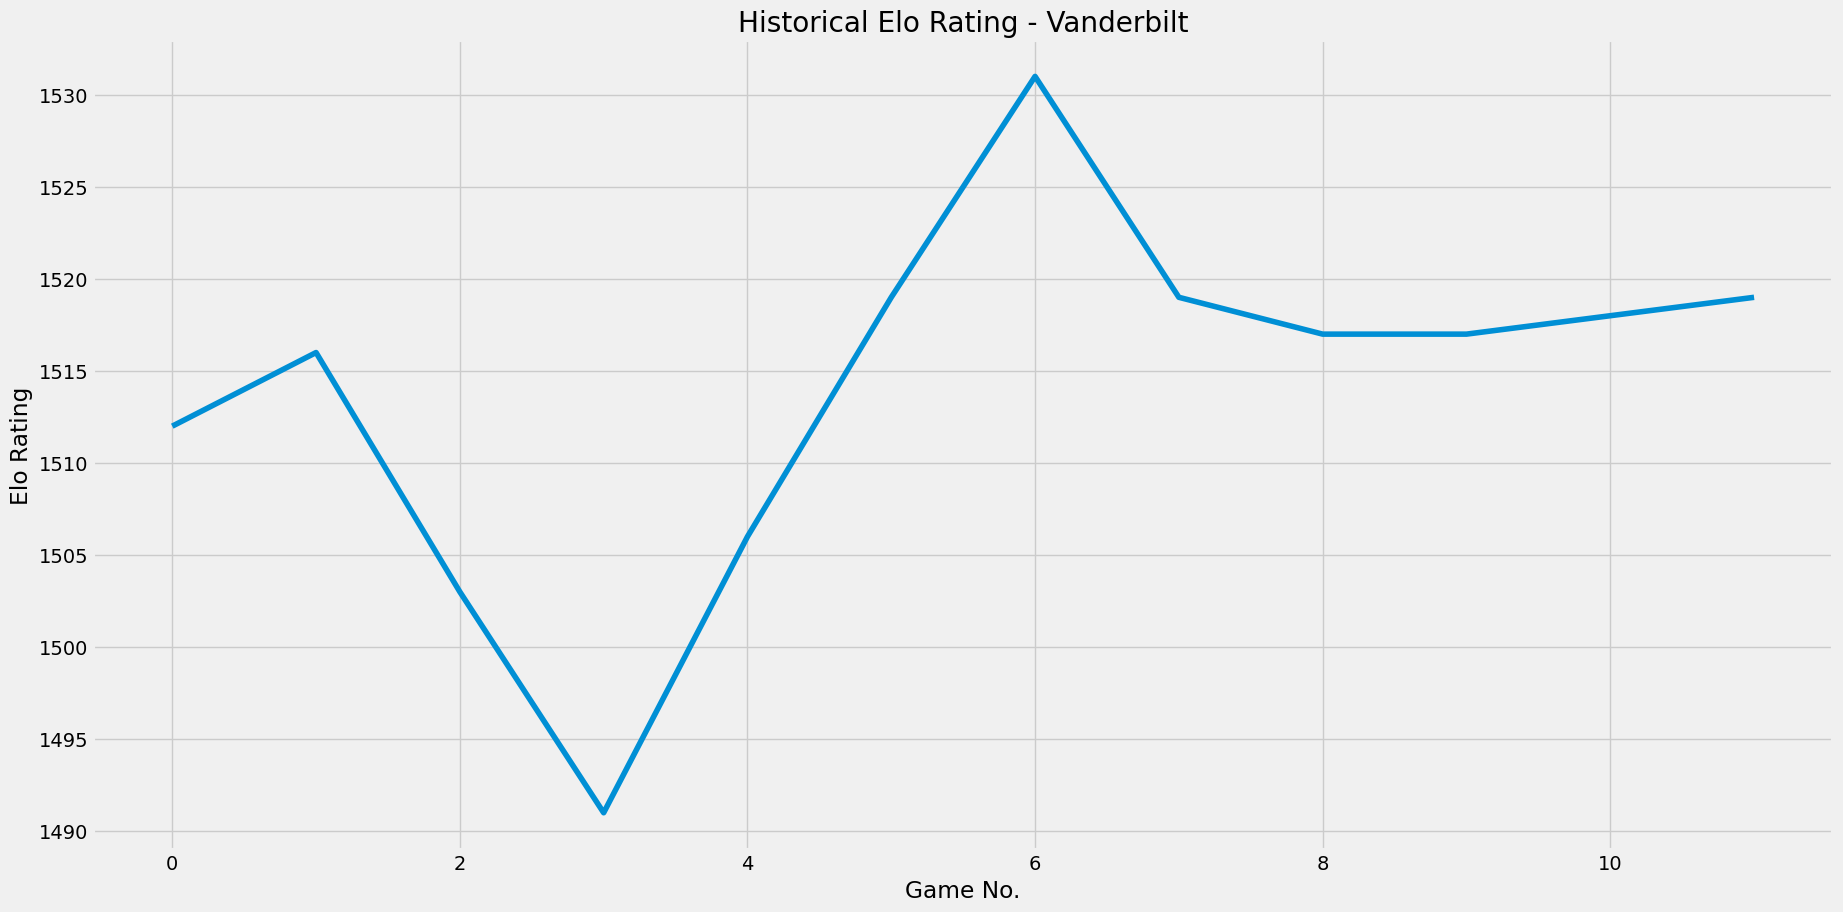

In [211]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = [20,10]

def generate_chart(team):
    team_games = []
    for _, game in games.iterrows():
        if game['home_team'] == team:
            team_games.append(dict(start_date=game['start_date'], elo=game['home_postgame_elo']))

        if game['away_team'] == team:
            team_games.append(dict(start_date=game['start_date'], elo=game['away_postgame_elo']))

    df = pd.DataFrame.from_records(team_games)

    fig, ax = plt.subplots()
    ax.plot(df.index, df['elo'])

    ax.set(xlabel='Game No.', ylabel='Elo Rating',
           title="Historical Elo Rating - {0}".format(team))

    plt.show()

generate_chart('Vanderbilt')